# 🆕 _Improved_ Wasserstein GAN

_hip_, _cool_ and ✨stable🌟 _generative adversarial network_. Based on a [paper by arjovsky, et al](https://arxiv.org/abs/1701.07875).

_Improved_ by [gulrajani et al](https://arxiv.org/abs/1704.00028)


In [1]:
import tensorflow as tf
import numpy as np
from nbutil import imshow_multi
import os
from tensorflow.contrib.layers.python.layers import batch_norm
from tensorflow.contrib.layers import xavier_initializer
from PIL import Image
import urllib, cStringIO
import cv2
import math
from simple import *

In [2]:
BATCH_SIZE = 16


In [3]:
from read_mnist import read_images, read_labels
def load_dataset(name):
    def featurize(image):
        return image.astype(float) / 255.0
    images = np.array([featurize(image) for image in read_images(name + '-images-idx3-ubyte')])
    labels = np.array([label for label in read_labels(name + '-labels-idx1-ubyte')])
    return images, labels
test_in, test_out = load_dataset('../data/t10k')
train_in, train_out = load_dataset('../data/train')

In [4]:
print test_in[0].shape

(28, 28)


In [5]:
# filename_queue = tf.train.string_input_producer(image_names, num_epochs=None)
# attr_queue = tf.train.input_producer(tf.constant(attr_vector), num_epochs=None)

def create_q():
    image_tensor = tf.convert_to_tensor(test_in, dtype=tf.float32)
    image_q = tf.train.slice_input_producer([image_tensor], num_epochs=None, shuffle=True)[0]
    images_batch = tf.train.shuffle_batch([image_q], batch_size=BATCH_SIZE, capacity=BATCH_SIZE*20, min_after_dequeue=BATCH_SIZE*10)
    images_batch = tf.expand_dims(images_batch, -1)
    images_batch = tf.image.resize_bilinear(images_batch, [32, 32])
    return images_batch

images_batch = create_q()


In [6]:
# session = tf.InteractiveSession()
# init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
# session.run(init_op)
# tf.train.start_queue_runners(sess=session)

In [7]:
def lrelu(x, alpha=0.2):
    return tf.maximum(alpha*x, x)

class WGAN(object):
    def __init__(self, images, scopename='wgan'):
        self.scopename = scopename
        with tf.variable_scope(scopename):
            batch_size, h, w, channels = [d.value for d in images.get_shape()]
            assert h == w
            z = tf.random_normal([batch_size, 128])
            fakes = self.generator(z, h, w, channels)
            
            fake_scores = self.critic(fakes)
            real_scores = self.critic(images, reuse=True)

            gen_loss = -tf.reduce_sum(fake_scores)
            LAMBDA = 10
            critic_loss = tf.reduce_sum(fake_scores - real_scores) + LAMBDA * self.gradient_penalty_loss(images, fakes)

            global_step = tf.contrib.framework.get_or_create_global_step()
            
            train_gen = self.optimize(gen_loss, 'gen', step=global_step)
            train_critic = self.optimize(critic_loss, 'critic')
            
            self.train_critic, self.train_gen = train_critic, train_gen
            self.critic_loss, self.gen_loss = critic_loss, gen_loss
            self.fakes = fakes
            self.global_step = global_step
    
    def optimize(self, loss, scope, step=None):
        var_list = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, self.scopename+'/'+scope)
        opt = tf.train.AdamOptimizer(0.0001, beta1=0.5, beta2=0.9)
        return opt.minimize(loss, var_list=var_list, global_step=step)
    
    def generator(self, z, h, w, channels):
        with tf.variable_scope('gen'):
            print 'GENERATOR:'
            n_layers = int(math.log(w) / math.log(2))
            base_chans = 8
            initial_chans = base_chans * 2 ** n_layers
            
            x = tf.layers.dense(z, initial_chans)
            x = tf.reshape(x, [-1, 1, 1, initial_chans])
            print x.get_shape()
            for i in xrange(n_layers):
                out_chans = x.get_shape()[-1].value / 2
                x = tf.layers.conv2d_transpose(x, out_chans, 5, strides=(2, 2), activation=lrelu, padding='SAME')
                x = tf.layers.batch_normalization(x, training=True)
                print x.get_shape()
            x = tf.layers.conv2d(x, channels, 1, activation=tf.tanh)
            print x.get_shape()
            
            return x
    
    def critic(self, images, reuse=False):
        with tf.variable_scope('critic', reuse=reuse):
            print 'CRITIC:'
            w = images.get_shape()[-2].value
            n_layers = int(math.log(w) / math.log(2))
            
            chans = 8
            x = tf.layers.conv2d(images, chans, 1)
            print x.get_shape()
            
            for i in xrange(n_layers):
                chans *= 2
                x = tf.layers.conv2d(x, chans, 5, (2, 2), activation=lrelu, padding='SAME')
                print x.get_shape()
            
            x = tf.layers.conv2d(x, 1, 1, activation=tf.identity)
            x = tf.reshape(x, [-1, 1])
            return x
    
    def gradient_penalty_loss(self, real, fake):
        batch_size = real.get_shape()[0].value
        alpha = tf.random_uniform([batch_size, 1, 1, 1])
        x_hat = real * alpha + fake * (1 - alpha)
        critic_output = self.critic(x_hat, reuse=True)
        grads = tf.gradients(critic_output, [x_hat])[0]
        slopes = tf.sqrt(tf.reduce_sum(tf.square(grads), reduction_indices=[1]))
        gradient_penalty = tf.reduce_mean((slopes - 1)**2)
        return gradient_penalty


In [8]:
w = WGAN(images_batch)

GENERATOR:
(16, 1, 1, 128)
(16, 2, 2, 64)
(16, 4, 4, 32)
(16, 8, 8, 16)
(16, 16, 16, 8)
(16, 32, 32, 4)
(16, 32, 32, 1)
CRITIC:
(16, 32, 32, 8)
(16, 16, 16, 16)
(16, 8, 8, 32)
(16, 4, 4, 64)
(16, 2, 2, 128)
(16, 1, 1, 256)
CRITIC:
(16, 32, 32, 8)
(16, 16, 16, 16)
(16, 8, 8, 32)
(16, 4, 4, 64)
(16, 2, 2, 128)
(16, 1, 1, 256)
CRITIC:
(16, 32, 32, 8)
(16, 16, 16, 16)
(16, 8, 8, 32)
(16, 4, 4, 64)
(16, 2, 2, 128)
(16, 1, 1, 256)


0: 9.77816314697


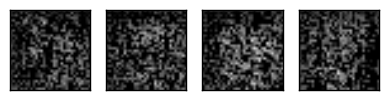

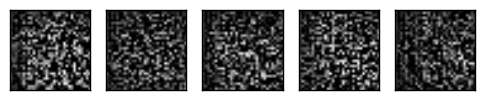

28: -5907.8910298


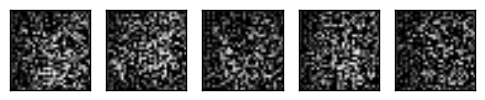

56: -22191.7461077


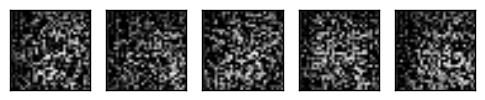

84: -25567.6946429


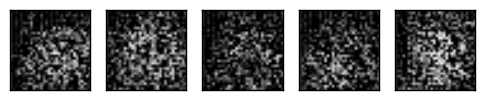

112: -24656.4848772


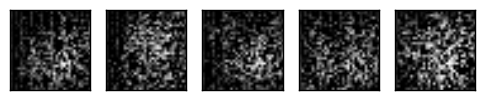

140: -22185.2689872


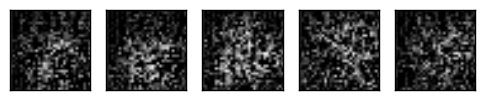

168: -19289.3868722


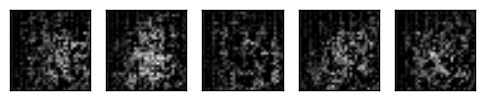

196: -15714.5694127


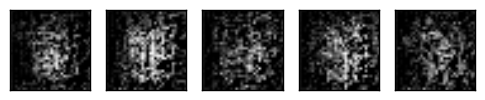

224: -11958.4622768


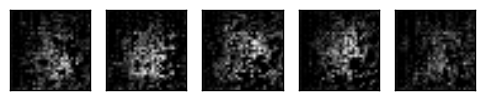

252: -9031.73318569


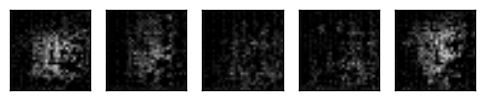

280: -7619.44386858


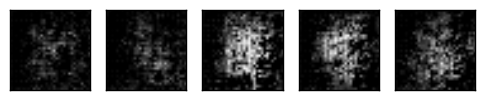

308: -6460.80957729


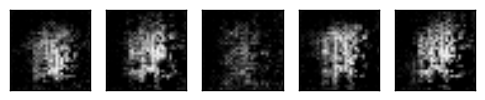

336: -5569.02688337


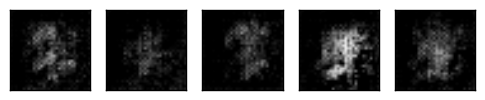

364: -4775.19164865


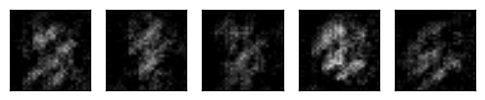

392: -3909.10631801


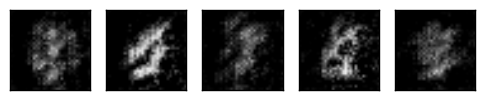

420: -3457.34118129


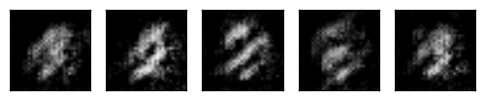

448: -3225.20704171


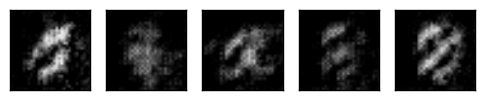

476: -3066.29157017


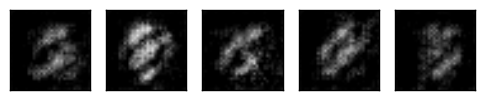

504: -2845.88527309


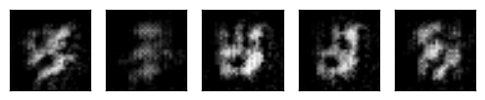

532: -2844.90400739


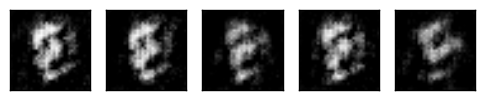

560: -2757.82880162


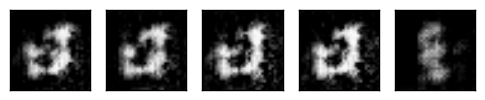

588: -2504.49042358


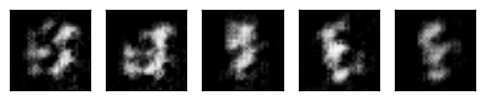

616: -2341.91446795


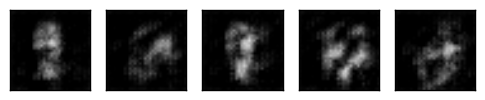

644: -2212.41339722


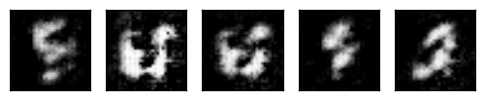

672: -2147.1145316


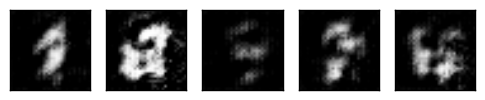

700: -2008.33115409


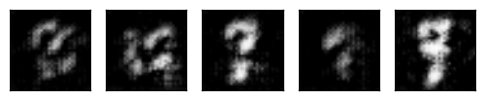

728: -1877.59315447


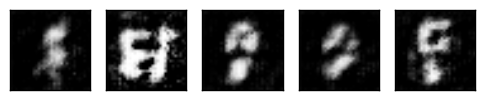

756: -1781.68460345


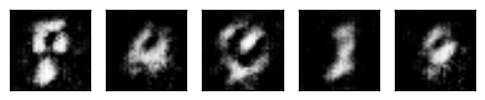

784: -1755.21710292


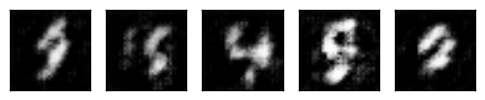

812: -1587.1949088


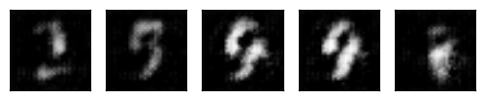

840: -1429.47638114


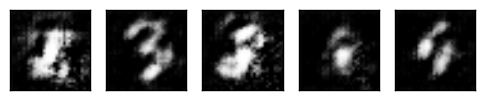

868: -1475.17150966


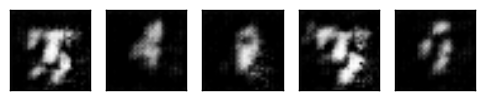

896: -1400.08628104


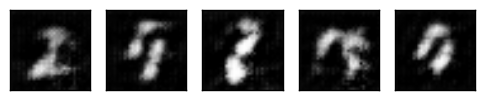

924: -1382.72524152


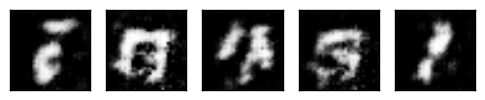

952: -1361.0869594


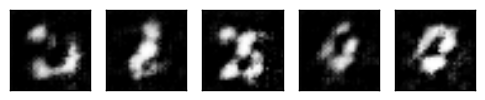

980: -1313.73706839


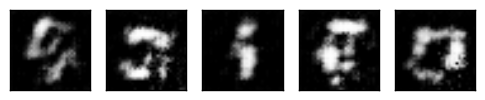

1008: -1285.73774981


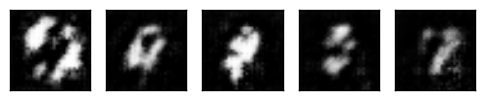

1036: -1244.76141357


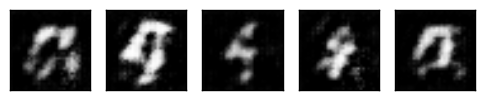

1064: -1243.46953953


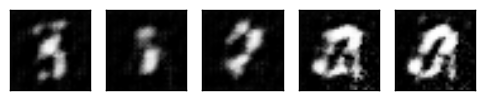

1092: -1174.53476432


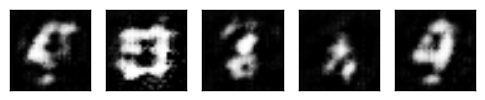

1120: -1126.50683376


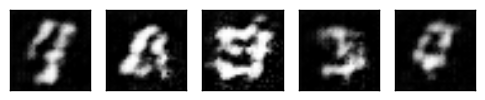

1148: -1138.77932216


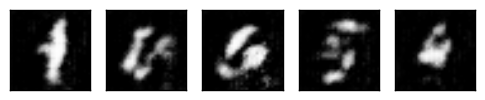

1176: -1110.33044695


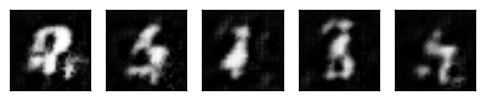

1204: -1101.62822571


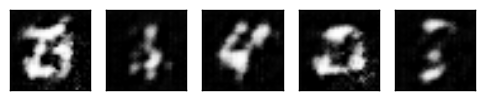

1232: -1119.31929932


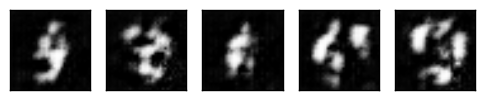

1260: -1118.84079546


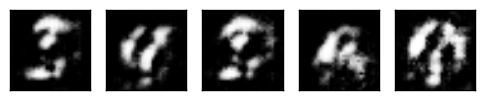

1288: -1100.57208165


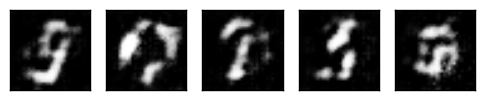

1316: -1063.1434954


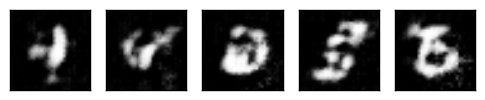

1344: -980.737987845


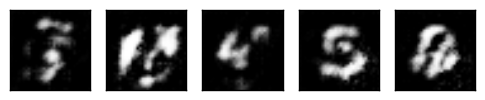

1372: -978.876940046


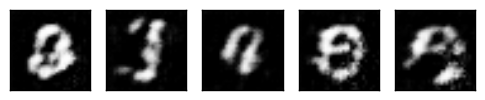

1400: -943.368484497


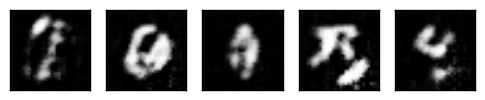

1428: -995.443659319


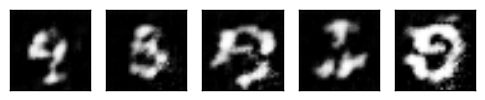

1456: -941.274720982


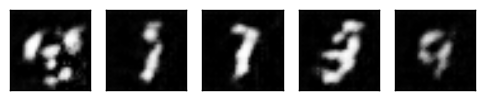

1484: -922.795654733


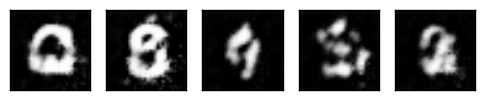

1512: -905.769131034


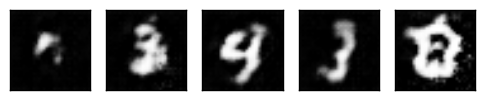

1540: -902.876705497


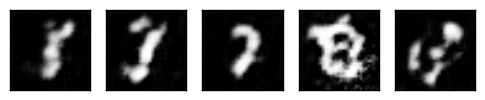

1568: -909.56666129


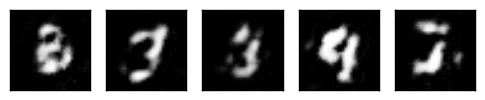

1596: -901.880240304


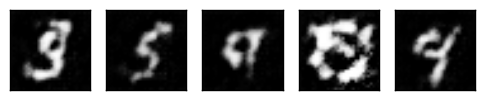

1624: -878.469217791


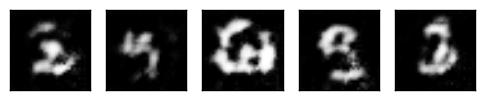

1652: -878.188907732


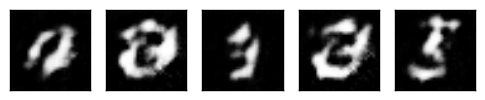

1680: -839.803916277


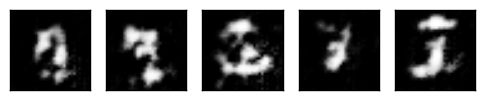

1708: -874.34666966


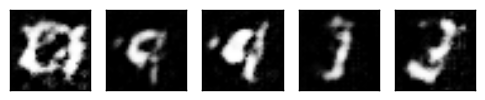

1736: -864.415018136


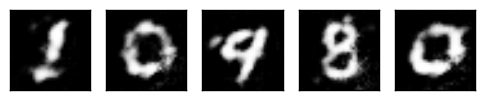

1764: -867.52759443


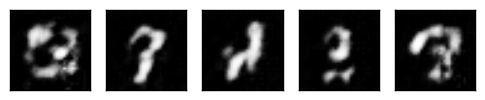

1792: -853.338396781


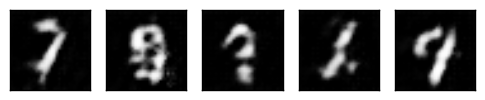

1820: -873.768362863


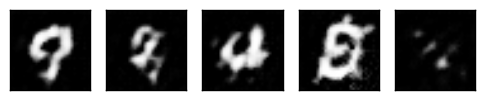

1848: -862.942522321


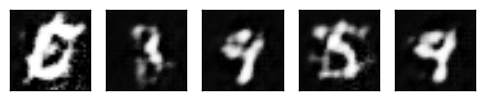

1876: -873.833127703


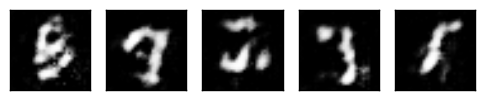

1904: -827.043609619


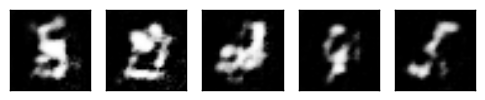

1932: -808.860936628


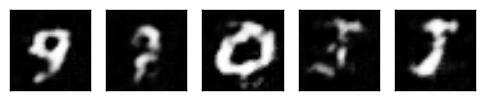

1960: -799.750385829


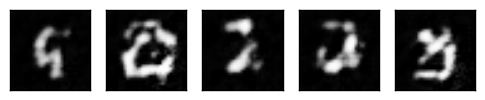

1988: -804.793809727


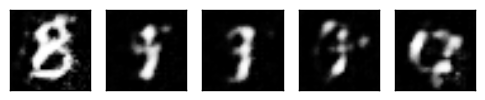

2016: -790.11620091


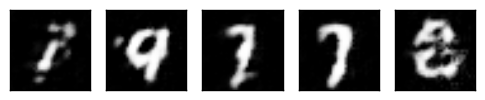

2044: -777.297450474


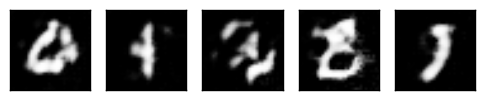

2072: -793.354279


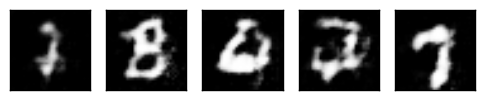

2100: -793.376758684


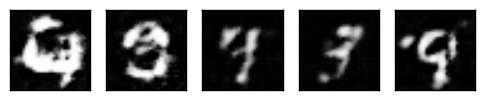

2128: -776.065921456


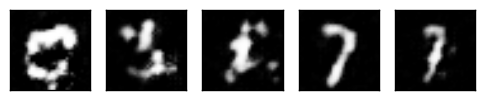

2156: -761.872158813


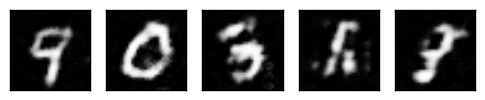

2184: -756.156612723


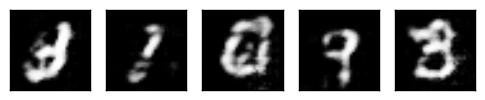

2212: -758.262528338


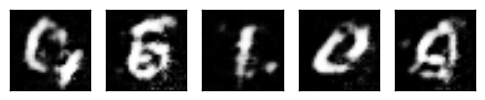

2240: -732.641898019


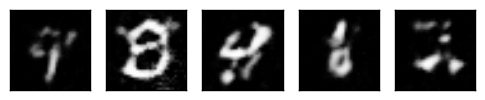

2268: -711.445733643


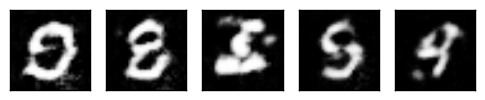

2296: -729.527403913


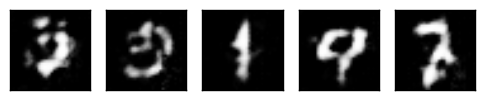

2324: -744.806891741


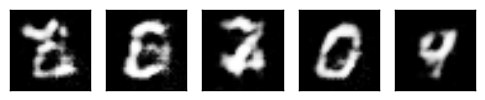

2352: -741.099322946


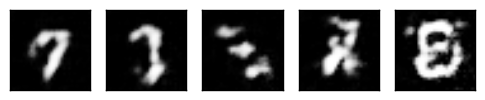

2380: -700.138378906


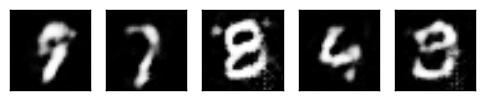

2408: -729.138293021


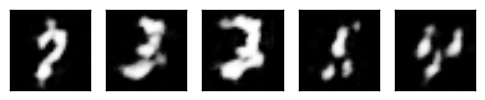

2436: -729.61844962


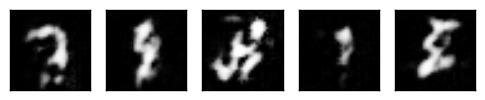

2464: -736.079466248


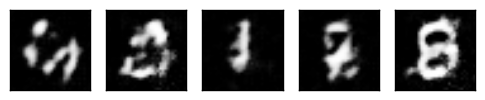

2492: -707.66726423


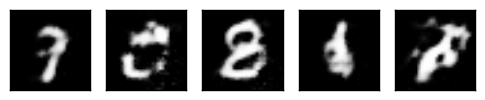

2520: -700.899241856


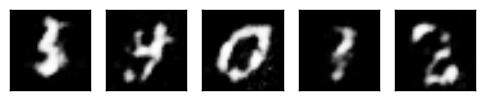

2548: -702.300571115


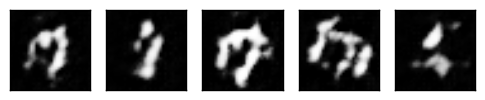

2576: -690.568906512


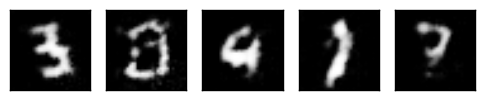

2604: -678.612261527


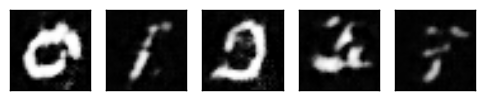

2632: -704.114851597


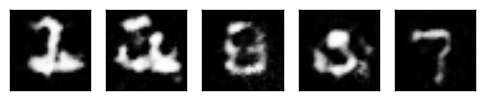

2660: -687.23674578


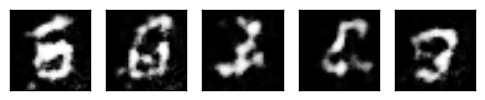

2688: -702.409894235


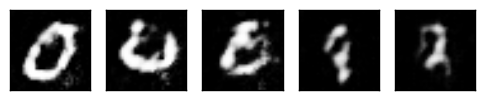

2716: -683.724197388


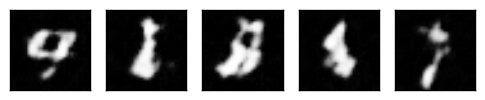

2744: -687.680418178


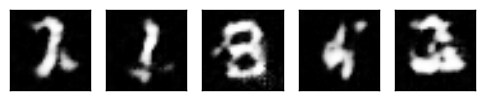

2772: -677.494847979


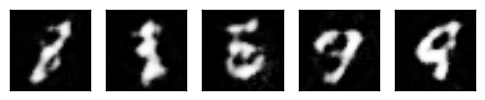

2800: -656.605032131


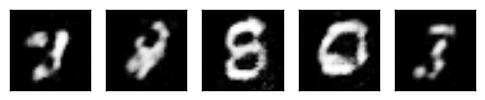

2828: -664.338614982


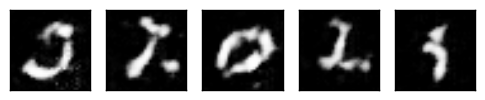

2856: -669.863456944


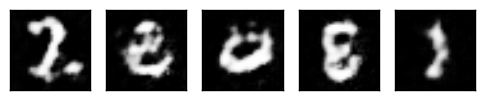

2884: -674.84748339


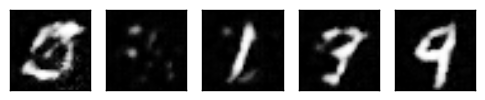

2912: -664.735565839


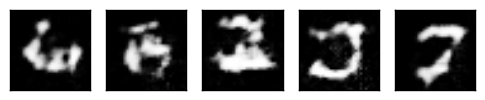

2940: -648.965863909


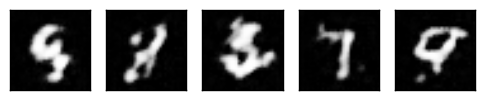

2968: -687.070027597


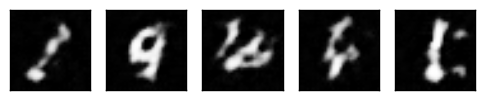

2996: -689.326045663


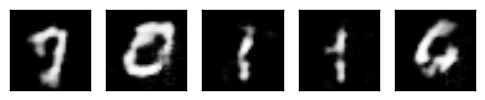

3024: -659.20927342


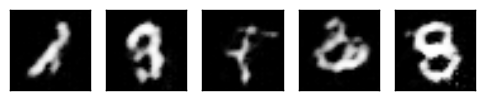

3052: -665.072405134


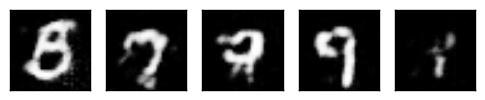

3080: -665.600065613


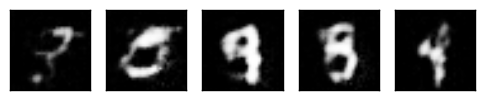

3108: -650.556623186


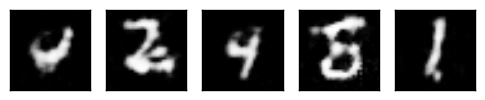

3136: -676.338615199


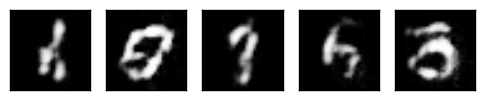

In [ ]:
CRITIC_TRAINS_PER_GEN = 5

sv = tf.train.Supervisor(logdir=None, save_model_secs=60 * 5)
with sv.managed_session() as sess:
    
    tf.train.start_queue_runners(sess=sess)
    
    losses = []
    
    while not sv.should_stop():
        step = sess.run(w.global_step)
        for i in xrange(CRITIC_TRAINS_PER_GEN):
            _, loss = sess.run([w.train_critic, w.critic_loss])
            losses.append(loss)
        _, fakes = sess.run([w.train_gen, w.fakes])
        
        if step % 28 == 0:
            print '{}: {}'.format(step, avg(losses))
            losses = []
            fakes = list(fakes[:5].reshape([5, 32, 32]))
            imshow_multi(fakes)
        